# scSpatial Seurat for CoexpressDeconvolve

In [1]:
# install.packages("Seurat")
# install.packages("viridis")

## Library import

In [2]:
library(Seurat)
library(ggplot2)
library(patchwork)
library(dplyr)
library(magrittr)
library(Matrix)
library(viridis)

set.seed(1)

# Multicore CPU usage activation - Future
library(future)

plan("multicore", workers = 10) 
# Set RAM Size to 3/4 of total RAM
options(future.globals.maxSize = 16e9)

future.seed=TRUE # Removes future-generated statistical errors

# Image Flip and Rotate functions

# -------------------------------------------------------------------
# Helper: compute centroid of existing coordinates
# -------------------------------------------------------------------
get_center <- function(obj, x = "center_x", y = "center_y") {
  df <- obj@meta.data
  cx <- mean(df[[x]], na.rm = TRUE)
  cy <- mean(df[[y]], na.rm = TRUE)
  c(cx = cx, cy = cy)
}

# -------------------------------------------------------------------
# Flip horizontally (mirror across vertical axis through centroid)
# -------------------------------------------------------------------
flip_horizontal <- function(obj, x = "center_x", y = "center_y") {
  ctr <- get_center(obj, x, y)
  obj@meta.data[[x]] <- 2 * ctr["cx"] - obj@meta.data[[x]]
  obj
}

# -------------------------------------------------------------------
# Flip vertically (mirror across horizontal axis through centroid)
# -------------------------------------------------------------------
flip_vertical <- function(obj, x = "center_x", y = "center_y") {
  ctr <- get_center(obj, x, y)
  obj@meta.data[[y]] <- 2 * ctr["cy"] - obj@meta.data[[y]]
  obj
}

# -------------------------------------------------------------------
# Rotate around centroid by 90° clockwise, 180°, or 270° (i.e. 90° CCW)
# angle must be one of: 90, 180, 270
# -------------------------------------------------------------------
rotate_coords <- function(obj, angle = 90, x = "center_x", y = "center_y") {
  if (! angle %in% c(90, 180, 270)) {
    stop("angle must be one of 90, 180, or 270 (degrees clockwise)")
  }
  df  <- obj@meta.data
  ctr <- get_center(obj, x, y)
  # translate to origin
  xx <- df[[x]] - ctr["cx"]
  yy <- df[[y]] - ctr["cy"]
  # apply rotation
  if (angle == 90) {
    xr <-  yy
    yr <- -xx
  } else if (angle == 180) {
    xr <- -xx
    yr <- -yy
  } else { # 270
    xr <- -yy
    yr <-  xx
  }
  # translate back
  obj@meta.data[[x]] <- xr + ctr["cx"]
  obj@meta.data[[y]] <- yr + ctr["cy"]
  obj
}

Warning message:
“пакет ‘Seurat’ был собран под R версии 4.3.3”
Загрузка требуемого пакета: SeuratObject

Warning message:
“пакет ‘SeuratObject’ был собран под R версии 4.3.3”
Загрузка требуемого пакета: sp


Присоединяю пакет: ‘SeuratObject’


Следующие объекты скрыты от ‘package:base’:

    intersect, t


Warning message:
“пакет ‘patchwork’ был собран под R версии 4.3.3”

Присоединяю пакет: ‘dplyr’


Следующие объекты скрыты от ‘package:stats’:

    filter, lag


Следующие объекты скрыты от ‘package:base’:

    intersect, setdiff, setequal, union


Загрузка требуемого пакета: viridisLite

Warning message:
“пакет ‘future’ был собран под R версии 4.3.3”


## Load data

In [5]:
Seurat <- Read10X(data.dir = "./deconvolved_feature_bc_matrix")
Seurat <- CreateSeuratObject(counts = Seurat)

# Load metadata
cell_metadata <- read.csv("cell_metadata.csv", stringsAsFactors = FALSE)
Seurat <- AddMetaData(Seurat, metadata = cell_metadata)

Seurat

An object of class Seurat 
11725 features across 116169 samples within 1 assay 
Active assay: RNA (11725 features, 0 variable features)
 1 layer present: counts

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



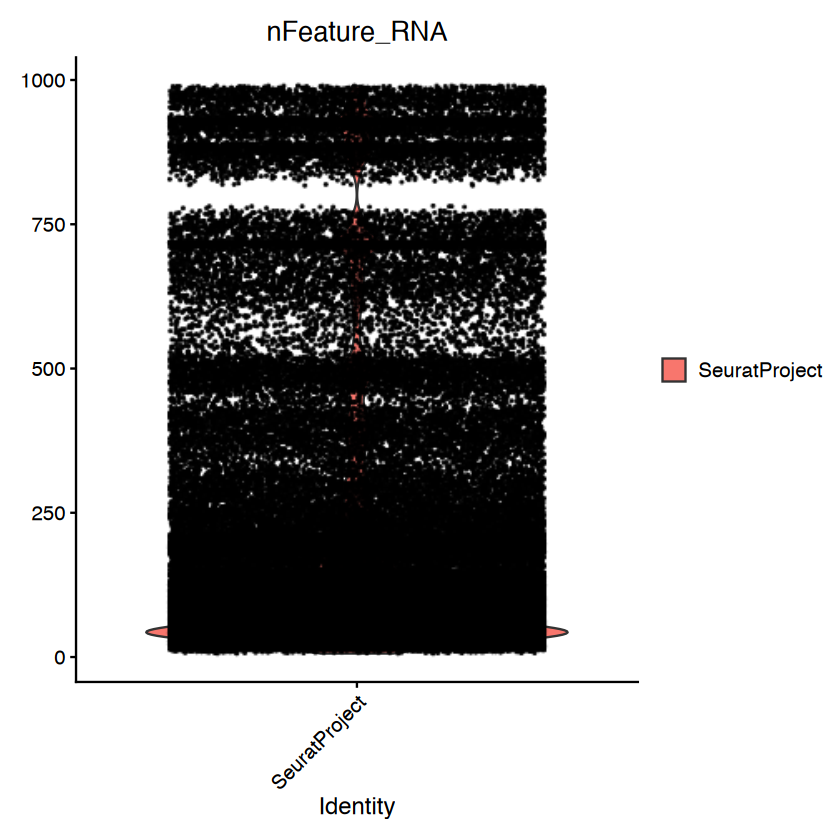

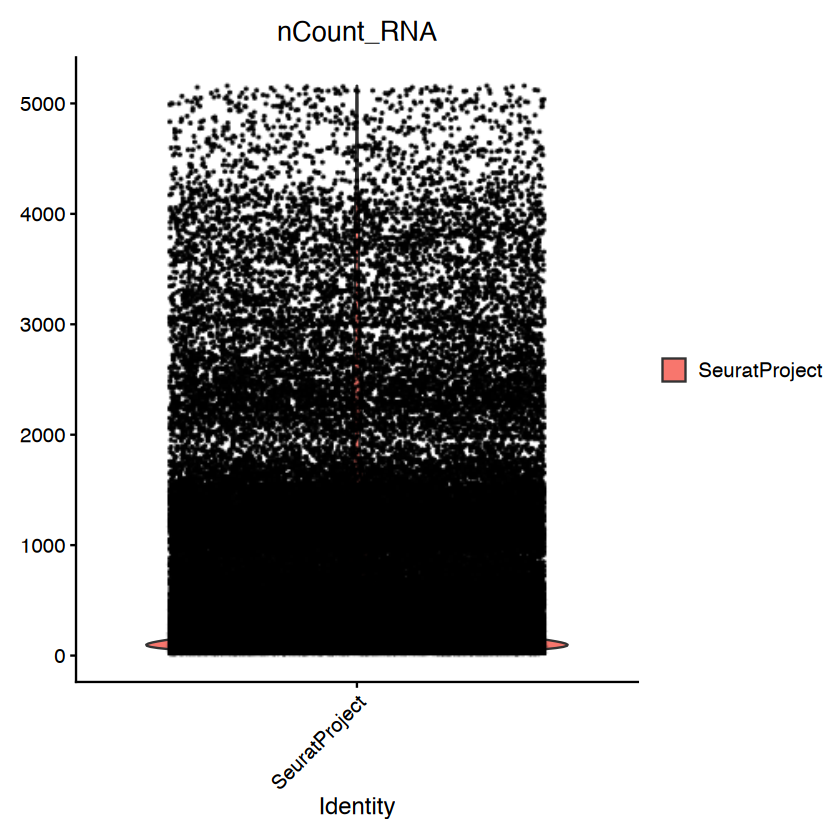

In [6]:
VlnPlot(Seurat, features = "nFeature_RNA")
VlnPlot(Seurat, features = "nCount_RNA")

In [8]:
Seurat <- NormalizeData(Seurat, normalization.method = "LogNormalize", scale.factor = 10000)
distance_clusters <- read.csv("cluster_info.csv")
Seurat <- AddMetaData(Seurat, metadata = distance_clusters$Cluster, col.name = "CellType")
Seurat <- SetIdent(Seurat, value = "CellType")

Seurat

Normalizing layer: counts



An object of class Seurat 
11725 features across 116169 samples within 1 assay 
Active assay: RNA (11725 features, 0 variable features)
 2 layers present: counts, data

In [9]:
head(Seurat@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,X,center_x,center_y,CellType
,<fct>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<int>
AACACCTACTATCGAA-1_10_1,SeuratProject,136,48,AACACCTACTATCGAA-1_10_1,4620.525,4106.959,10
AACACCTACTATCGAA-1_10_2,SeuratProject,136,48,AACACCTACTATCGAA-1_10_2,4715.652,4220.332,10
AACACCTACTATCGAA-1_19_1,SeuratProject,67,60,AACACCTACTATCGAA-1_19_1,4559.096,4096.968,19
AACACCTACTATCGAA-1_19_2,SeuratProject,67,60,AACACCTACTATCGAA-1_19_2,4563.492,4150.134,19
AACACCTACTATCGAA-1_14_1,SeuratProject,106,47,AACACCTACTATCGAA-1_14_1,4742.276,4113.414,14
AACACCTACTATCGAA-1_14_2,SeuratProject,106,47,AACACCTACTATCGAA-1_14_2,4582.937,4035.570,14


In [10]:
# Mirror and Rotate the slide

# # Mirror left↔right
# Seurat <- flip_horizontal(Seurat)

# # Mirror up↔down
# Seurat <- flip_vertical(Seurat)

# # Rotate 90° clockwise
# Seurat <- rotate_coords(Seurat,  90)

# # Rotate 180°
# Seurat <- rotate_coords(Seurat, 180)

# # Rotate 90° counter‐clockwise
# Seurat <- rotate_coords(Seurat, 270)

## Spatial Cluster Plot

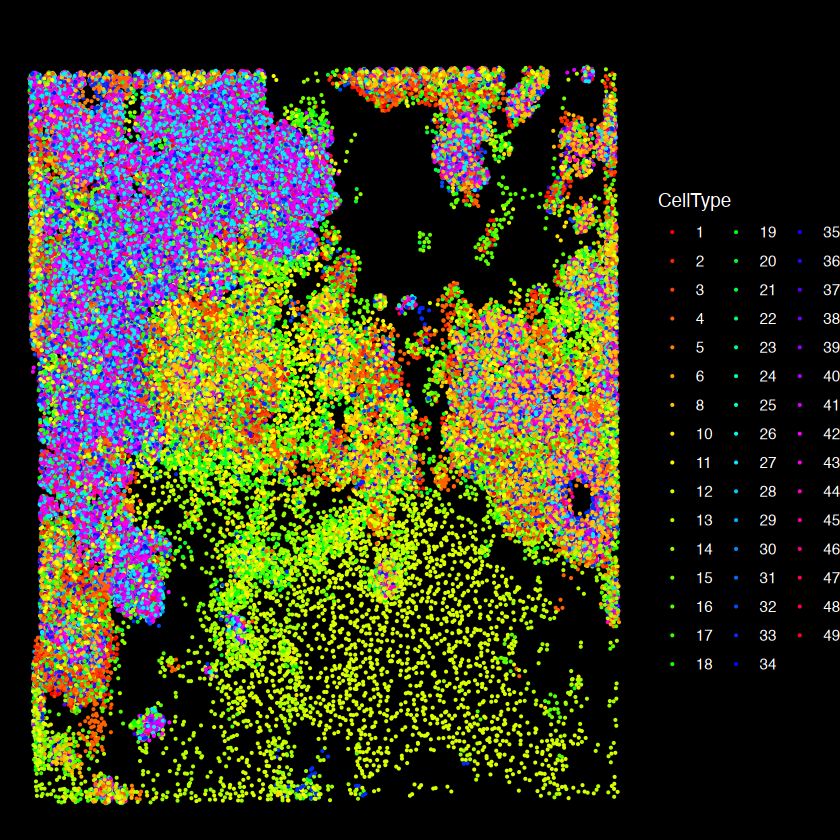

In [12]:
Seurat@meta.data$center_x <- as.numeric(Seurat@meta.data$center_x)
Seurat@meta.data$center_y <- as.numeric(Seurat@meta.data$center_y)

# Plot clusters with black background
ggplot(Seurat@meta.data, aes(x = center_x, y = center_y, color = as.factor(CellType))) +
  geom_point(size = 0.1) +
  scale_color_manual(values = rainbow(length(unique(Seurat$CellType)))) + # Custom colors
  theme_void() +  # Remove axis
  theme(panel.background = element_rect(fill = "black", color = "black"), 
        plot.background = element_rect(fill = "black"),
        legend.text = element_text(color = "white"),
        legend.title = element_text(color = "white")) +
  labs(title = "Spatial Plot of Clusters", color = "CellType")

ggsave(
  "Spatial Cluster Plot.jpeg",
  plot = last_plot(),
  device = "jpeg",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 42,
  height = 40,
  units = "cm",
  dpi = 600,
  limitsize = TRUE,
#   bg = NULL,
)

## Spatial Feaute Plot

In [ ]:
# Define the genes you want to plot
genes <- c("TNFRSF1B", "IGKC", "TRBC1", "COL3A1")  # Replace with actual gene names

# Ensure spatial coordinates are numeric
Seurat@meta.data$center_x <- as.numeric(Seurat@meta.data$center_x)
Seurat@meta.data$center_y <- as.numeric(Seurat@meta.data$center_y)

# Convert Seurat object to a data frame for plotting
expression_data <- Seurat@meta.data
for (gene in genes) {
  expression_data[[gene]] <- as.numeric(FetchData(Seurat, vars = gene)[,1])  # Ensure numeric
}

# Generate individual gene expression plots
plot_list <- lapply(genes, function(gene) {
  ggplot(expression_data, aes(x = center_x, y = center_y, color = !!sym(gene))) +
    geom_point(size = 0.25) +
    scale_color_viridis_c(option = "viridis") +  # Use a continuous color scale
    theme_void() +
    theme(
      panel.background = element_rect(fill = "black", color = "black"), 
      plot.background = element_rect(fill = "black"),
      legend.text = element_text(color = "white"),
      legend.title = element_text(color = "white"),
      plot.title = element_text(family = "Helvetica", face = "bold", color = "white", hjust = 0.5, size = 18), # Title settings
      plot.margin = margin(0, 0, 0, 0)  # Remove extra margins
    ) +
    labs(title = gene, color = "")  # Title = Gene name
})

# Arrange plots in a 2x2 grid and remove the outer border
final_plot <- wrap_plots(plot_list, ncol = 2) +
  plot_annotation(theme = theme(plot.background = element_rect(fill = "black", color = NA)))  # Remove outer white border

ggsave( 
  "Spatial Feaute Plot.jpeg",
  plot = last_plot(),
  device = "jpeg",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 44,
  height = 40,
  units = "cm",
  dpi = 600,
  limitsize = TRUE,
#   bg = NULL,
)

## Spatial Subcluster Plot

In [ ]:
# Convert spatial coordinates to numeric
Seurat@meta.data$center_x <- as.numeric(Seurat@meta.data$center_x)
Seurat@meta.data$center_y <- as.numeric(Seurat@meta.data$center_y)

# Filter for clusters 29, 3, and 6
subset_meta <- Seurat@meta.data[Seurat@meta.data$CellType %in% c(29, 20, 15), ]

# Define custom colors for selected clusters
custom_colors <- c("29" = "purple", "20" = "green", "15" = "yellow")  # Customize as needed

# Plot clusters with black background
ggplot(subset_meta, aes(x = center_x, y = center_y, color = as.factor(CellType))) +
  geom_point(size = 1) +
  scale_color_manual(values = custom_colors) + # Use custom colors
  theme_void() +  # Remove axis
  theme(panel.background = element_rect(fill = "black", color = "black"), 
        plot.background = element_rect(fill = "black"),
        legend.text = element_text(color = "white"),
        legend.title = element_text(color = "white")) +
  labs(title = "Spatial Plot of Selected Clusters", color = "Cluster")

ggsave(
  "Spatial SubCluster Plot.jpeg",
  plot = last_plot(),
  device = "jpeg",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 42,
  height = 40,
  units = "cm",
  dpi = 600,
  limitsize = TRUE,
#   bg = NULL,
)

## FOV selection

In [17]:
# Define FOV boundaries
x_min <- 0
x_max <- 16000
y_min <- 0
y_max <- 12000

# Filter cells within the FOV
subset_cells <- rownames(Seurat@meta.data[
  Seurat@meta.data$center_x >= x_min & 
  Seurat@meta.data$center_x <= x_max & 
  Seurat@meta.data$center_y >= y_min & 
  Seurat@meta.data$center_y <= y_max, 
])

# Subset Seurat object
Seurat_FOV <- subset(Seurat, cells = subset_cells)

# Check dimensions of the new object
print(dim(Seurat_FOV))

[1] 11725 66335


## FOV Spatial Cluster Plot

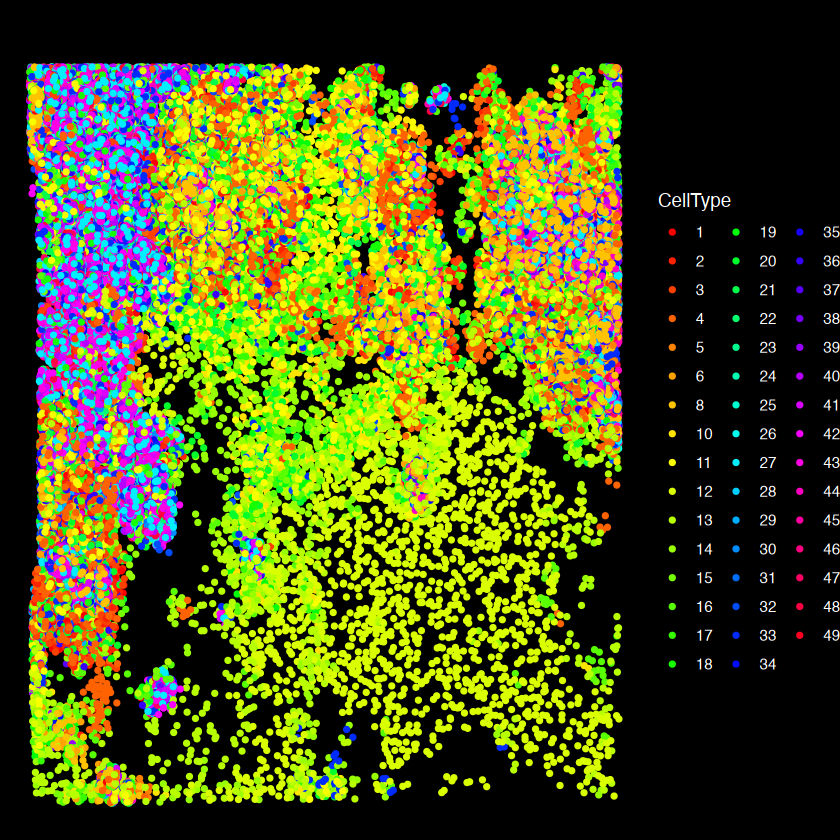

In [18]:
Seurat_FOV@meta.data$center_x <- as.numeric(Seurat_FOV@meta.data$center_x)
Seurat_FOV@meta.data$center_y <- as.numeric(Seurat_FOV@meta.data$center_y)

# Plot clusters with black background
ggplot(Seurat_FOV@meta.data, aes(x = center_x, y = center_y, color = as.factor(CellType))) +
  geom_point(size = 1) +
  scale_color_manual(values = rainbow(length(unique(Seurat_FOV$CellType)))) + # Custom colors
  theme_void() +  # Remove axis
  theme(panel.background = element_rect(fill = "black", color = "black"), 
        plot.background = element_rect(fill = "black"),
        legend.text = element_text(color = "white"),
        legend.title = element_text(color = "white")) +
  labs(title = "Spatial Plot of Clusters", color = "CellType")

ggsave(
  "Spatial FOV Cluster Plot.jpeg",
  plot = last_plot(),
  device = "jpeg",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 42,
  height = 30,
  units = "cm",
  dpi = 600,
  limitsize = TRUE,
#   bg = NULL,
)

## Find Top Genes Per Distance Cluster

In [ ]:
deg0 <- FindMarkers(Seurat, ident.1 = '14', only.pos = FALSE, logfc.threshold = 1., min.pct = 0.9)
deg0 <- deg0[order(deg0$avg_log2FC,decreasing=TRUE),]
deg0

## Rename Clusters 

In [ ]:
levels(Seurat) <- c('1','2','3','4','5','6','7','8','9','10',
                    '11','12','13','14','15','16','17','18','19','20',
                   '21','22','23','24','25','26','27','28','29','30','31')

new.cluster.ids <- c('1','2','3','4','5','6','7','8','9','10',
                    '11','12','13','14','15','16','17','18','19','20',
                   '21','22','23','24','25','26','27','28','29','30','31')

names(new.cluster.ids) <- levels(Seurat)

Seurat <- RenameIdents(Seurat, new.cluster.ids)

Seurat$CellType <- Idents(Seurat)

## Dot plot of the distance cluster genes

In [ ]:
all.genes <- rownames(Seurat)
Seurat <- ScaleData(Seurat, features = all.genes)

In [ ]:
cluster_features = c('SKIL', 'RELL1', 'OAF', # 1
                     'CRABP2', 'MMP3', 'FAM102A', # 2
                     'RHOB', 'MYC', 'COX14', # 3
                     'CD14','FCGR3A', 'HLA-DMA', 'HLA-DQA1', 'CXCR4', 'TRAC', 'TRBC1', 'TRBC2', # 4
                     'COL1A2', 'SPARC', 'TPM2', # 5
                     'NR4A1', 'PLA2G2A', 'FOSB', # 6
                     'ASPN', 'COLEC12', 'CXCL12', # 7
                     'EMP1', 'C1S', 'IL1R1', # 8
                     'TGFBR2', 'TNFRSF14', 'EHBP1L1', # 9
                     'AQP1', 'VWF', 'PECAM1', # 10
                     'TNFRSF1B', 'DHRS3', 'ALPL', # 11
                     'ACTC1', 'DES', 'MB', # 12
                     'COL1A1', 'MT1X', 'CIRBP', # 13
                     'SLC2A5', 'PADI2', 'TCEA3', # 14
                     'COL3A1', 'FN1', 'COL6A3', 'ACTB','CD74', # 15
                     'ENO1', 'MICOS10', 'NBL1', # 16
                     'AGRN', 'CTNNBIP1', 'MFAP2', # 17
                     'INTS11', 'CCNL2', 'SSU72', # 18
                     'ICMT', 'ATP5IF1', 'MAP7D1', # 19
                     'IGKC','IGLC1', 'IGKV4-1','S100A8','S100A9', # 20
                     'NADK', 'NPHP4', 'NOL9',  # 21
                     'PRKCZ', 'PER3', 'UBE4B', # 22
                     'UBE2J2', 'ACAP3', 'VWA1', # 23
                     'CDC20', 'HIST2H2AB', 'TACC3', # 24
                     'NOC2L', 'B3GALT6', 'AURKAIP1', # 25
                     'IFI44L', 'IFI44', 'GBP5', # 26
                     'HES4', 'CPTP', 'UBR4', # 27
                     'LCE3E', 'LCE3D', 'IVL', # 28
                     'GRHL3', 'PDZK1IP1', 'CRCT1', # 29
                     'DVL1', 'AJAP1', 'CASZ1', # 30
                     'PLCH2', 'TPRG1L', 'GPR153' # 31
                     )

DotPlot(Seurat, features = cluster_features) + RotatedAxis() + scale_colour_viridis() +DarkTheme()

# Save the last plot

ggsave(
  "Dot plot.jpeg",
  plot = last_plot(),
  device = "jpeg",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 68,
  height = 25,
  units = "cm",
  dpi = 600,
  limitsize = TRUE,
#   bg = NULL,
)

## Cell cluster percentage stacked bar plot

In [ ]:
cluster_counts <- as.data.frame(table(Seurat@meta.data$CellType))
colnames(cluster_counts) <- c("Cluster", "CellCount")
cluster_counts$Percentage <- (cluster_counts$CellCount / sum(cluster_counts$CellCount)) * 100

# Define custom colors (change if needed)
custom_colors <- rainbow(length(unique(cluster_counts$Cluster)))

# Create the stacked bar plot with percentages
ggplot(cluster_counts, aes(x = "", y = Percentage, fill = as.factor(Cluster))) +
  geom_bar(stat = "identity", width = 1) +
  scale_fill_manual(values = custom_colors) +  # Use custom colors
  theme_dark() +  # Apply dark theme
  labs(title = "Cluster Distribution (Percentage)", y = "Percentage of Cells", fill = "Cluster") +
  theme(
    panel.background = element_rect(fill = "black", color = NA),   # Black background
    plot.background = element_rect(fill = "black", color = NA),    # Black plot area
    panel.grid.major = element_line(color = "gray30"),  # Dark gray grid
    panel.grid.minor = element_blank(),
    axis.text = element_text(color = "white"),   # White axis text
    axis.title = element_text(color = "white"),  # White axis title
    legend.background = element_rect(fill = "black"),  # Dark legend
    legend.text = element_text(color = "white"),
    legend.title = element_text(color = "white")
  ) +
  scale_y_continuous(labels = scales::percent_format(scale = 1))  # Show percentages on y-axis

ggsave(
  "Cell Stacked Bar Plot.jpeg",
  plot = last_plot(),
  device = "jpeg",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 6,
  height = 40,
  units = "cm",
  dpi = 600,
  limitsize = TRUE,
#   bg = NULL,
)

# Neighbourhood analysis

In [ ]:
# Calculate cell cluster distances

library(ComplexHeatmap)
library(circlize)

# Extract spatial coordinates and CellType
df <- Seurat@meta.data %>%
  select(center_x, center_y, CellType)

# Define chunk size
chunk_size <- 1000  # Adjust based on available RAM
num_chunks <- ceiling(nrow(df) / chunk_size)

# Create an empty distance matrix for CellTypes
celltypes <- unique(df$CellType)
celltype_dist <- matrix(NA, length(celltypes), length(celltypes), dimnames = list(celltypes, celltypes))

# Function to compute pairwise distances for a chunk
compute_chunk_distances <- function(chunk) {
  dist_mat <- as.matrix(dist(chunk[, c("center_x", "center_y")]))  # Euclidean distance
  return(dist_mat)
}

# Process in chunks
for (i in seq_len(num_chunks)) {
  cat("Processing chunk", i, "of", num_chunks, "\n")
  
  # Get chunk of data
  chunk <- df[((i - 1) * chunk_size + 1):min(i * chunk_size, nrow(df)), ]
  
  # Compute pairwise distances
  dist_chunk <- compute_chunk_distances(chunk)
  
  # Update the CellType distance matrix (average per CellType)
  for (ct1 in unique(chunk$CellType)) {
    for (ct2 in unique(chunk$CellType)) {
      if (ct1 != ct2) {
        dists <- dist_chunk[chunk$CellType == ct1, chunk$CellType == ct2]
        celltype_dist[ct1, ct2] <- mean(dists, na.rm = TRUE)  # Average distance
      }
    }
  }
}

# Convert distance to similarity (1 - normalized distance)
celltype_similarity <- 1 - (celltype_dist / max(celltype_dist, na.rm = TRUE))

In [ ]:
# Create a heatmap with hierarchical clustering

col_fun <- colorRamp2(c(0, 0.5, 1), c("blue", "white", "red"))

jpeg("CellType Neighbourhood Heatmap.jpeg", width = 4750, height = 4000, res = 600)

Heatmap(as.matrix(celltype_similarity),
        name = "Co-localization",
        col = col_fun,  # Apply the corrected colormap
        # cluster_rows = TRUE, 
        # cluster_columns = TRUE,
        show_heatmap_legend = TRUE)  # Ensure legend is displayed

dev.off()

In [ ]:
# Subset for co-localized cell types
Seurat_co_localized <- subset(Seurat, subset = CellType %in% c('15','16','26','24','11','10','4','12','27','21','29','17'))
Seurat_co_localized

In [ ]:
Seurat_co_localized@meta.data$center_x <- as.numeric(Seurat_co_localized@meta.data$center_x)
Seurat_co_localized@meta.data$center_y <- as.numeric(Seurat_co_localized@meta.data$center_y)

# Plot clusters with black background
ggplot(Seurat_co_localized@meta.data, aes(x = center_x, y = center_y, color = as.factor(CellType))) +
  geom_point(size = 2) +
  scale_color_manual(values = rainbow(length(unique(Seurat_co_localized$CellType)))) + # Custom colors
  theme_void() +  # Remove axis
  theme(panel.background = element_rect(fill = "black", color = "black"), 
        plot.background = element_rect(fill = "black"),
        legend.text = element_text(color = "white"),
        legend.title = element_text(color = "white")) +
  labs(title = "Spatial Plot of Clusters", color = "CellType")

ggsave(
  "Spatial Co-localized Clusters' Plot.jpeg",
  plot = last_plot(),
  device = "jpeg",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 41,
  height = 40,
  units = "cm",
  dpi = 600,
  limitsize = TRUE,
#   bg = NULL,
)

# Cell-Cell Communication Analysis of the co-localized cell clusters

In [ ]:
library(CellChat)
library(patchwork)
library(ggalluvial)
library(igraph)

In [ ]:
CellChat <- createCellChat(Seurat_co_localized,
#                               group.by = 'Sample',
                              # assay = 'SCT',
                              do.sparse = T)

CellChatDB <- CellChatDB.human

CellChatDB.use <- CellChatDB
CellChat@DB <- CellChatDB.use
CellChat <- subsetData(CellChat)
CellChat <- identifyOverExpressedGenes(CellChat)
CellChat <- identifyOverExpressedInteractions(CellChat)

CellChat <- projectData(CellChat, PPI.human)

CellChat <- computeCommunProb(CellChat)

CellChat <- computeCommunProbPathway(CellChat)

CellChat <- aggregateNet(CellChat)

library(NMF)
library(ggalluvial)

In [ ]:
CellChat@netP$pathways

In [ ]:
selectK(CellChat, pattern = "outgoing")

In [ ]:
selectK(CellChat, pattern = "incoming")

In [ ]:
nPatterns = 3
CellChat <- identifyCommunicationPatterns(CellChat, 
                                          pattern = "outgoing", 
                                          k = nPatterns)
nPatterns = 2
CellChat <- identifyCommunicationPatterns(CellChat, 
                                          pattern = "incoming", 
                                          k = nPatterns)

In [ ]:
# river plot
netAnalysis_river(CellChat, pattern = "outgoing")

ggsave(
  "River Plot Outgoing.jpeg",
  plot = last_plot(),
  device = "jpeg",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 20,
  height = 20,
  units = "cm",
  dpi = 600,
  limitsize = TRUE,
#   bg = NULL,
)

In [ ]:
# river plot
netAnalysis_river(CellChat, pattern = "incoming")

ggsave(
  "River Plot Incoming.jpeg",
  plot = last_plot(),
  device = "jpeg",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 20,
  height = 20,
  units = "cm",
  dpi = 600,
  limitsize = TRUE,
#   bg = NULL,
)

In [ ]:
# Dot plot of outgoing communications
netAnalysis_dot(CellChat, pattern = "outgoing")

ggsave(
  "Dot Plot Outgoing.jpeg",
  plot = last_plot(),
  device = "jpeg",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 22,
  height = 14,
  units = "cm",
  dpi = 600,
  limitsize = TRUE,
#   bg = NULL,
)

In [ ]:
# Dot plot of incoming communications
netAnalysis_dot(CellChat, pattern = "incoming")

ggsave(
  "Dot Plot Incoming.jpeg",
  plot = last_plot(),
  device = "jpeg",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 22,
  height = 14,
  units = "cm",
  dpi = 600,
  limitsize = TRUE,
#   bg = NULL,
)